In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.patches as patches

from scipy.stats import gaussian_kde as GKDE
from scipy.stats import multivariate_normal
from scipy.stats import norm
import scipy.integrate as integrate

import weightedCDFs as wCDFs
import weights

import matplotlib as mpl

In [2]:
mpl.rcParams['lines.linewidth'] = 4
plt.rc('font', size=14)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['figure.figsize'] = (5.5, 4)
mpl.rcParams['lines.linewidth'] = 2.5

CB_color_cycle = ('#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=CB_color_cycle) 

## Problem setup

In [3]:
random.seed(20)

In [4]:
l = 2.
kappa = 1.

In [5]:
N = 100  # Specify the truncation
ts = [1e-4, 1e-2, 1e-1, 0.4, 0.8]
x = np.linspace(0, l, 2*N)

In [6]:
def u_k(k, x, t, l, kappa):
    
    return (2 * l**2 * (-1)**(k+1) / (np.pi * k)
            * np.sin(k * np.pi * x / l)
            * np.exp(-kappa * (k * np.pi)**2 * t) / l**2)

def u(N, x, t, l, kappa):
    
    u_N = 0 * x
    for k in range(1, N):
        u_N += u_k(k, x, t, l, kappa)

    return u_N

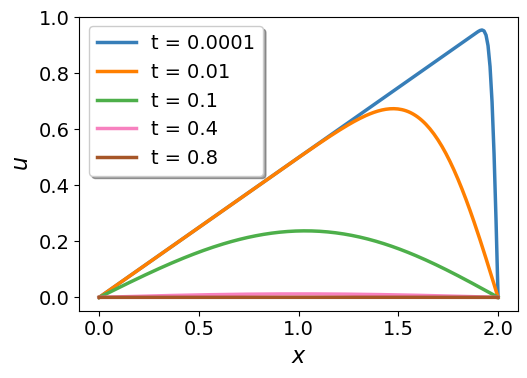

In [7]:
for t in ts:

    u_N = u(N, x, t, l, kappa)
    plt.plot(x, u_N, label='t = ' + str(t));

plt.legend(loc='upper left', shadow=True)
plt.xlabel('$x$')
plt.ylabel('$u$')

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/paper/heat_eq_sol.png', bbox_inches='tight')

In [8]:
ts = [.01]
sensor_loc = 1.2

## Setup the standard DCI problem

In [9]:
n_init_samples = 2000

delta_l = 0.1
delta_kappa = 0.5

init_samples = np.random.uniform(0, 1, (n_init_samples,2))
init_samples[:,0] = init_samples[:,0] * delta_l + l - delta_l / 2
init_samples[:,1] = init_samples[:,1] * delta_kappa + kappa - delta_kappa / 2

In [10]:
X = np.linspace(l - delta_l / 2, delta_l + l - delta_l / 2, 100)
Y = np.linspace(kappa - delta_kappa / 2, delta_kappa + kappa - delta_kappa / 2, 100)

XX, YY = np.meshgrid(X, Y)
ZZ = np.zeros(np.shape(XX))

for count, x in enumerate(X):
    ZZ[count,:] = u(N, sensor_loc, ts[0], XX[count,:], YY[count,:])

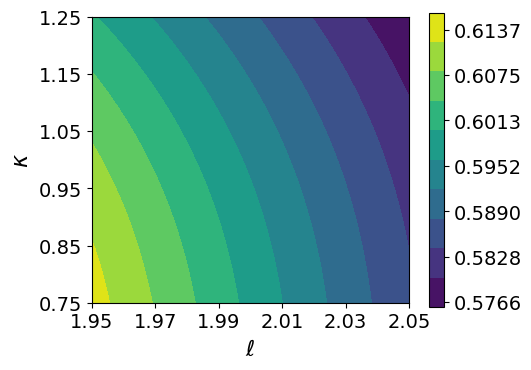

In [11]:
plt.contourf(XX, YY, ZZ, levels=9);
ax = plt.gca()
ax.set_aspect(0.18)

plt.ylabel(r'$\kappa$');
plt.xlabel(r'$\ell$');
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(ZZ), np.max(ZZ), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(ZZ),
                                                             np.max(ZZ), 7)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/paper/contours.png', bbox_inches='tight')

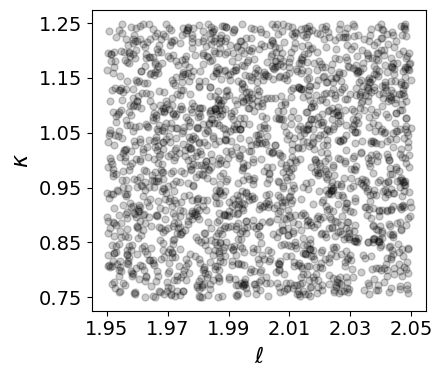

In [12]:
plt.scatter(init_samples[:,0], init_samples[:,1], alpha=0.2, color='k')
ax = plt.gca()
ax.set_aspect(0.18)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/paper/heat_eq_init_samples.png', bbox_inches='tight')

In [13]:
pred_samples = np.zeros((n_init_samples, len(ts)))
for count, t in enumerate(ts):
    pred_samples[:, count] = u(N, sensor_loc, t, init_samples[:,0], init_samples[:,1])
    
pred_KDE = GKDE(pred_samples[:,0])

In [14]:
obs_dist = norm(0.595, 3e-3)

n_obs_samples = 1000
obs_samples = obs_dist.rvs(n_obs_samples)

obs_KDE = GKDE(obs_samples)

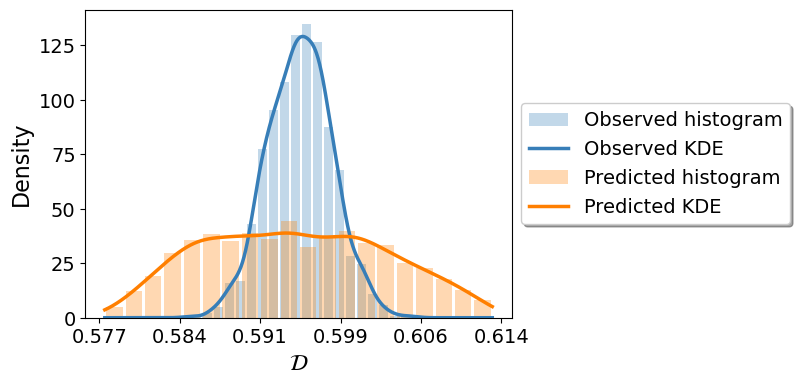

In [15]:
xx = np.linspace(np.min(pred_samples), np.max(pred_samples), 1000)

plt.hist(obs_samples, bins=20, alpha=0.3, density=True, label='Observed histogram', rwidth=0.85);
plt.plot(xx, obs_KDE(xx), color=CB_color_cycle[0], label='Observed KDE')

plt.hist(pred_samples, bins=20, alpha=0.3, density=True, label='Predicted histogram', rwidth=0.85);
plt.plot(xx, pred_KDE(xx), color=CB_color_cycle[1], label='Predicted KDE')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True)
plt.xlabel(r'$\mathcal{D}$')
plt.xticks(ticks=np.linspace(np.min(ZZ), np.max(ZZ), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(ZZ), np.max(ZZ), 6)])
plt.ylabel('Density')

plt.savefig(f'/Users/kirana/Desktop/work/paper/heat_eq_dists.png', bbox_inches='tight')

## Density-based solution

In [16]:
r = obs_KDE(pred_samples.T) / pred_KDE(pred_samples.T)
rn_w = r / n_init_samples
print(f'E(r) = {np.mean(r)}')

E(r) = 1.001328747824113


In [17]:
def rejection_sampling(r):
    
    unifs = np.random.uniform(0,1,len(r))
    M = np.max(r)
    
    return (unifs < (r / M))

In [18]:
update_inds = rejection_sampling(r)

update_samples = init_samples[update_inds]

pf_samples = pred_samples[update_inds]

pf_KDE = GKDE(pf_samples.T)

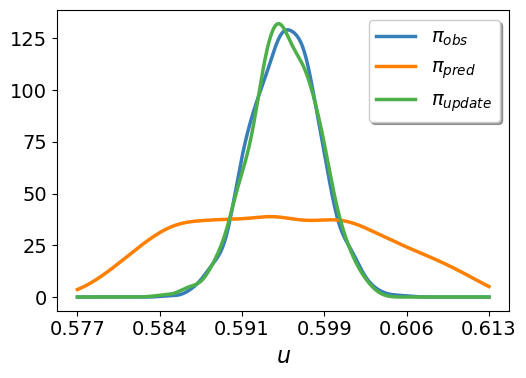

In [19]:
xx = np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 1000)

plt.plot(xx, obs_KDE(xx), label=r'$\pi_{obs}$')
plt.plot(xx, pred_KDE(xx), label=r'$\pi_{pred}$')
plt.plot(xx, pf_KDE(xx), label=r'$\pi_{update}$')

plt.xticks(ticks=np.linspace(np.min(pred_samples), np.max(pred_samples), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(pred_samples), np.max(pred_samples), 6)])
plt.xlabel('$u$')
plt.legend(shadow=True)

plt.tight_layout()
plt.savefig('/Users/kirana/Desktop/work/paper/dens_results.png', bbox_inches='tight')

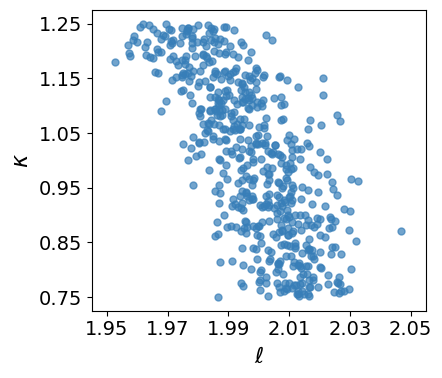

In [20]:
plt.scatter(init_samples[update_inds,0], init_samples[update_inds,1], alpha=0.7)

ax = plt.gca()
ax.set_aspect(0.18)

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/paper/rejection.png', bbox_inches='tight')

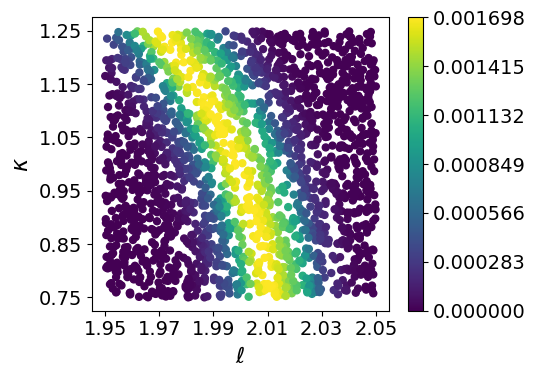

In [21]:
ax = plt.gca()

plt.scatter(init_samples[:,0], init_samples[:,1], c=r/n_init_samples)

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(r/n_init_samples), np.max(r/n_init_samples), 7))
cbar.set_ticklabels(["{:.6f}".format(x) for x in np.linspace(np.min(r/n_init_samples),
                                                             np.max(r/n_init_samples), 7)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/paper/hist_rn_weights.png', bbox_inches='tight')

In [85]:
def histogram_dci(init_samples, pred_samples, bbox=None,
                  sample_set_2=None, targ_CDF=None, n_bins=None,
                  remove_empty_bins=True):

    # print(len(pred_samples))
    # print(len(sample_set_2))
    n_samples = len(pred_samples)
    dim_D = np.shape(pred_samples)[1]

    # if n_clusters is not input, then use n_clusters = n_samples / 100
    if n_bins is None: # idk this isn't going to work well in multiple dimensions
        n_bins = (n_samples / 100)
    if isinstance(n_bins, int):
        n_bins = [n_bins] * dim_D
        
    if bbox is not None:
        if dim_D == 1:
            min_pred = bbox[0]
            max_pred = bbox[1]

    else:
        if dim_D == 1:
            min_pred = np.min(pred_samples[:,0])
            max_pred = np.max(pred_samples[:,0])

    # create bins in each dimension
    low_ends = np.empty((np.prod(n_bins), dim_D))
    upp_ends = np.empty((np.prod(n_bins), dim_D))
    if dim_D == 1:
        d_len = (max_pred - min_pred) / n_bins[0]
        low_ends[:,0] = np.linspace(min_pred, max_pred-d_len, n_bins[0])
        upp_ends[:,0] = np.linspace(min_pred+d_len, max_pred, n_bins[0])

    # ok for now this is only going to work in 1 or 2 dimensions because it's fucking recursive again!!!!!!
    # bin samples
    labels = np.empty(n_samples)
    ratios = []
    in_bins_pred = []
    in_bins_obs = []
    n_obs = len(sample_set_2)
    if dim_D == 1:
        counter = 0
        for i in range(n_bins[0]):
            bin_inds = ((pred_samples[:,0] >= low_ends[i,0]) & (pred_samples[:,0] <= upp_ends[i,0]))
            labels[bin_inds] = counter
            ratios.append(np.sum((sample_set_2[:,0] >= low_ends[i,0]) & (sample_set_2[:,0] <= upp_ends[i,0]))/n_obs)
            in_bins_pred.append((np.sum(((pred_samples[:,0] >= low_ends[i,0]) & (pred_samples[:,0] <= upp_ends[i,0])))))
            in_bins_obs.append((np.sum(((sample_set_2[:,0] >= low_ends[i,0]) & (sample_set_2[:,0] <= upp_ends[i,0])))))
            counter += 1

    ratios = np.array(ratios)
    in_bins_pred = np.array(in_bins_pred)
    in_bins_obs = np.array(in_bins_obs)
    w = weights.distributeWeights(init_samples, labels, ratios)
    len_bin = upp_ends[0,0] - low_ends[0,0]
    return w, ratios, labels, in_bins_pred, in_bins_obs, len_bin, low_ends, upp_ends

In [86]:
n_bins = 35

In [87]:
w, ratios, bins, in_bins_pred, in_bins_obs, len_bin, low_ends, upp_ends = histogram_dci(init_samples, pred_samples,
                             sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)), n_bins=n_bins)

In [88]:
# np.sum(ratios)
np.sum(w)

1.0

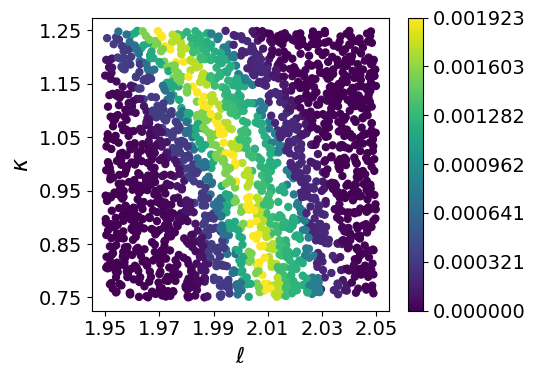

In [89]:
plt.scatter(init_samples[:,0], init_samples[:,1], c=w)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(w), np.max(w), 7))
cbar.set_ticklabels(["{:.6f}".format(x) for x in np.linspace(np.min(w),
                                                             np.max(w), 7)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/paper/hist_hweights.png', bbox_inches='tight')

In [90]:
print(np.sum(w))

1.0


## Binning methods

### Regular partitioning

In [91]:
rpartitioned_w, bins, centers, w_center = weights.computePartitionedWeights_regulargrid_IID(init_samples,
                                                                        pred_samples,
                                                                        sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)),
                                                                        n_bins=n_bins)
rpartitioned_w = rpartitioned_w / n_bins

In [92]:
print(np.sum(rpartitioned_w))

0.9999999999999996


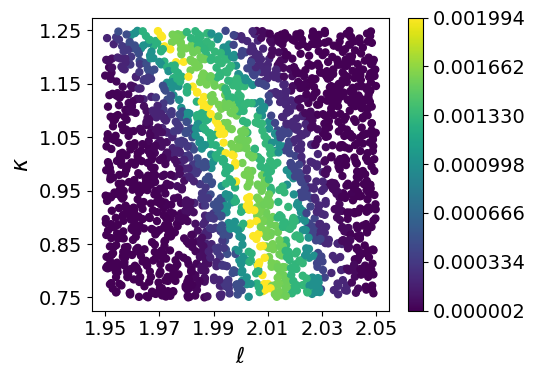

In [93]:
plt.scatter(init_samples[:,0], init_samples[:,1], c=rpartitioned_w)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(rpartitioned_w), np.max(rpartitioned_w), 7))
cbar.set_ticklabels(["{:.6f}".format(x) for x in np.linspace(np.min(rpartitioned_w),
                                                             np.max(rpartitioned_w), 7)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/paper/hist_regpart_weights.png', bbox_inches='tight')

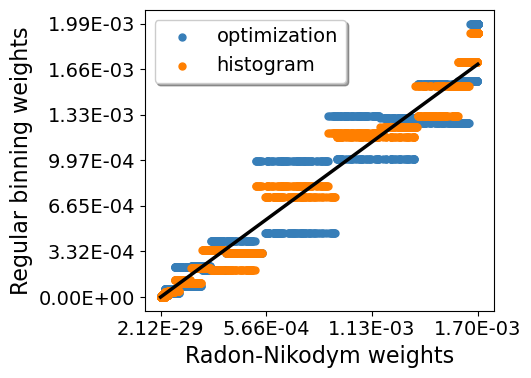

In [94]:
plt.scatter(rn_w, rpartitioned_w, label='optimization')
plt.scatter(rn_w, w, label='histogram')
plt.plot(np.linspace(0, np.max(rn_w), 1000),
         np.linspace(0, np.max(rn_w), 1000), color='k')

min_plot = np.min([np.min(rpartitioned_w), np.min(w)])
max_plot = np.max([np.max(rpartitioned_w), np.max(w)])
plt.xticks(ticks=np.linspace(np.min(rn_w), np.max(rn_w), 4),
           labels=["{:.2E}".format(x) for x in np.linspace(np.min(rn_w), np.max(rn_w), 4)])
plt.yticks(ticks=np.linspace(min_plot, max_plot, 7),
           labels=["{:.2E}".format(x) for x in np.linspace(min_plot, max_plot, 7)])
plt.xlabel('Radon-Nikodym weights')
plt.ylabel('Regular binning weights')

plt.tight_layout()
plt.legend(shadow=True)
plt.savefig(f'/Users/kirana/Desktop/work/paper/hist_weights_comp.png', bbox_inches='tight')

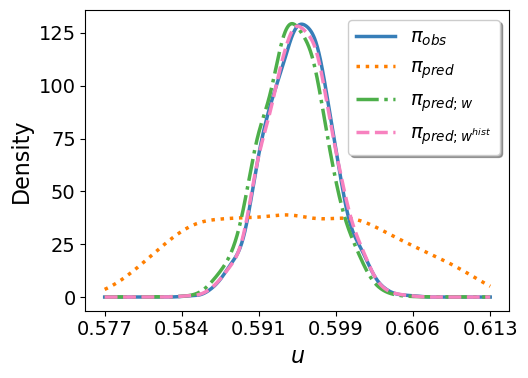

In [95]:
xx = np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 1000)

rn_pf_KDE = GKDE(pred_samples.T, weights=rn_w)
regpart_pf_KDE = GKDE(pred_samples.T, weights=rpartitioned_w)
hist_pf_KDE = GKDE(pred_samples.T, weights=w)

plt.plot(xx, obs_KDE(xx), label=r'$\pi_{obs}$', ls='-')
plt.plot(xx, pred_KDE(xx), label=r'$\pi_{pred}$', ls=':')
plt.plot(xx, regpart_pf_KDE(xx), label=r'$\pi_{pred;w}$', ls='-.')
plt.plot(xx, hist_pf_KDE(xx), label=r'$\pi_{pred;w^{hist}}$', ls='--')

plt.xticks(ticks=np.linspace(np.min(pred_samples), np.max(pred_samples), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(pred_samples), np.max(pred_samples), 6)])
plt.xlabel(r'$u$')
plt.ylabel('Density')
plt.legend(shadow=True)

plt.tight_layout()
plt.savefig('/Users/kirana/Desktop/work/paper/hist_densities.png', bbox_inches='tight')

In [96]:
# def F_hist(x_vals, hist_obj):
def F_hist(x_vals, vals, bins):

    F_vals = np.zeros(len(x_vals))
    # vals, bins, plot = hist_obj
    for count, x in enumerate(x_vals):
        if x < bins[0]: val = 0
        elif x > bins[-1]: val = 1
        else:
            val = 0
            in_bin = (x < bins[1:]) & (x > bins[:-1])
            for bin_ind in range(len(in_bin)):
                if in_bin[bin_ind]:
                    val += vals[bin_ind] * (x - bins[bin_ind])
                    break
                else:
                    val += vals[bin_ind] * (bins[bin_ind + 1] - bins[bin_ind])
        F_vals[count] = val
    return F_vals

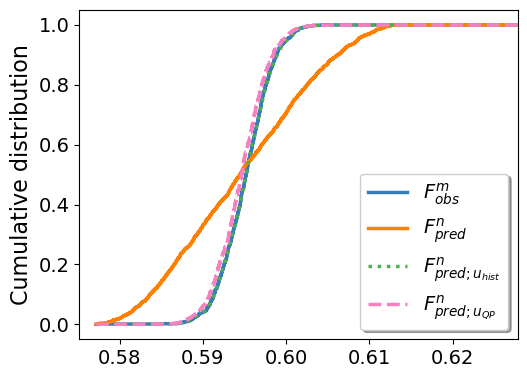

In [105]:
isort = np.argsort(pred_samples[:,0])
isort_obs = np.argsort(obs_samples)
isort_centers = np.argsort(centers)

plt.step(np.append(np.min(pred_samples[:,0]), np.append(obs_samples[isort_obs], np.max(pred_samples[:,0])+0.015)),
         np.append(0, np.append(np.cumsum([1/n_obs_samples]*n_obs_samples), 1)),
         label=r'$F^m_{obs}$')
plt.step(np.append(pred_samples[isort,0], np.max(pred_samples[:,0])+0.015),
         np.append(np.cumsum([1/n_init_samples]*n_init_samples), 1), label=r'$F^n_{pred}$')
# F_h = F_hist(xx, ratios, np.append(low_ends, low_ends[-1]+len_bin))
plt.plot(upp_ends, np.cumsum(ratios), label=r'$F^n_{pred;u_{hist}}$', ls=':', color=CB_color_cycle[2])
# plt.step(np.append(pred_samples[isort,0], np.max(pred_samples[:,0])+0.015),
#          np.append(np.cumsum(w[isort]), np.sum(w)), label=r'$F^n_{pred;w_{hist}}$', ls=':')
plt.step(np.append(pred_samples[isort,0], np.max(pred_samples[:,0])+0.015),
         np.append(np.cumsum(rpartitioned_w[isort]), 1), label=r'$F^n_{pred;u_{QP}}$', ls='--', color=CB_color_cycle[3])

# plt.xlabel(r'$\mathcal{D}$')
plt.xlim(np.min(pred_samples[:,0]-0.002), np.max(pred_samples[:,0]+0.015))
plt.ylabel('Cumulative distribution')
plt.legend(loc='lower right', shadow=True)

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/hist_cdfs.png', bbox_inches='tight')

In [98]:
print(np.sum(w))

1.0


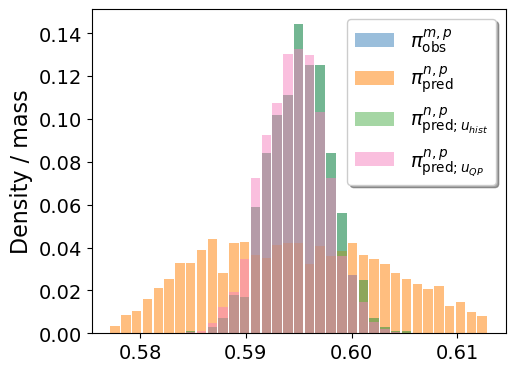

In [104]:
plt.bar(centers[:,0], in_bins_obs/n_obs_samples,
        width=(centers[1]-centers[0])-(centers[1]-centers[0])/8,
        alpha=0.5, label=r'$\pi^{m,p}_{\text{obs}}$')
plt.bar(centers[:,0], in_bins_pred/n_init_samples,
        width=(centers[1]-centers[0])-(centers[1]-centers[0])/8,
        alpha=0.5, label=r'$\pi^{n,p}_{\text{pred}}$')
# plt.bar(centers[:,0], w_center[:,0]/n_bins,
#         width=(centers[1]-centers[0])-(centers[1]-centers[0])/8,
#         alpha=0.5, label=r'$\pi^n_{\text{pred};w}$')
plt.bar(centers[:,0], ratios,
        width=(centers[1]-centers[0])-(centers[1]-centers[0])/8,
        alpha=0.5, label=r'$\pi^{n,p}_{\text{pred};{u_{hist}}}$')
plt.bar(centers[:,0], w_center[:,0]/len(centers[:,0]),
        width=(centers[1]-centers[0])-(centers[1]-centers[0])/8,
        alpha=0.5, label=r'$\pi^{n,p}_{\text{pred};{u_{QP}}}$')
plt.legend(shadow=True)
plt.ylabel('Density / mass')
plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/hists.png', bbox_inches='tight')